# Predict Price with Weather data

Import Related Libraries

In [159]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from tqdm import tqdm

Load in and merge weather data

In [210]:
# Load in Weather and IGS data
igs_data = pd.read_csv("updated_igs_data.csv", index_col = 0)
hourly_weather = pd.read_csv("houston_hourly_weather_data.csv")

# Merge Data
hourly_weather["datetime"] = pd.to_datetime(hourly_weather["datetime"])
igs_data["LOCAL_FROM_DATETIME"] = pd.to_datetime(igs_data["LOCAL_FROM_DATETIME"])
price_df = igs_data.merge(hourly_weather, how = "left", left_on = "LOCAL_FROM_DATETIME", right_on = "datetime")

Clean Merged Data

In [211]:

# Rename and Add Columns
price_df.rename(columns = {"Delivery Date":"DateTime"}, inplace = True)
price_df["Month_Int"] = price_df["LOCAL_FROM_DATETIME"].apply(lambda d: d.month)

#Replace 'Settlement Point Price' with the actual column name from your CSV if it's different.
price_df['Settlement_Point_Price'] = pd.to_numeric(price_df['Settlement Point Price'], errors='coerce')
price_df['QUANTITY'] = pd.to_numeric(price_df['QUANTITY'], errors='coerce')

# Set 'DateTime' as the index
price_df.set_index('DateTime', inplace=True)

# Sort the DataFrame by DateTime to ensure it is in chronological order
price_df.sort_index(inplace=True)

price_df = price_df[price_df["ACCOUNT_NUMBER"] == "account_a"]

# Prices are the same for each account so we can take prices from a single account



In [212]:
 #, #, "Hour", "Holiday", "Day", "Weekend", "temp"]]
important_vars = ["Settlement_Point_Price", "Month_Int", "temp", "Hour"]

# Days of the month greater than or equal to 25
val_data = price_df[price_df["Day"] >= 25]
val_data = val_data[important_vars].astype(float)
val_data = val_data.dropna()

# Days of the month between 3 and 25 exclusively
train_data = price_df[(price_df["Day"] > 3) & (price_df["Day"] < 25)]
train_data = train_data[important_vars].astype(float)
train_data = train_data.dropna()

Function to create sequences of data

In [213]:
def create_sequences(data, seq_length):
    xs = []
    ys = []

    # Create Rolling Windows
    for i in range(len(data) - seq_length):
        xs.append(data.iloc[i:(i + seq_length)])
        ys.append(data.iloc[i + seq_length])

    # Torch Arrays
    xs = torch.tensor(np.array(xs), dtype=torch.float32)
    ys = torch.tensor(np.array(ys), dtype=torch.float32)
    
    # Only need price for Y
    ys = ys[:,:1]
    
    return xs, ys

Our LSTM Model Architecture:

In [214]:
# Create Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class CustomLSTM(nn.Module):
    def __init__(self, lstm_input_size, hidden_size, num_layers, output_size, aux_input_size = None, aux_hidden_size = None):
        super(CustomLSTM, self).__init__()

        # LSTM Layer
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(lstm_input_size, hidden_size, num_layers, batch_first=True)
        
        # Linear layer code:
        #self.aux_lin = torch.nn.Linear(aux_input_size, aux_hidden_size)

        ## Join Layer
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x_time):

        h_0 = torch.zeros(self.num_layers, x_time.size(0), self.hidden_size).to(device)
        c_0 = torch.zeros(self.num_layers, x_time.size(0), self.hidden_size).to(device)

        # LSTM Output
        out, _ = self.lstm(x_time, (h_0, c_0))

        # Transform into output
        out = self.fc(out[:, -1, :])

        return out

Dataset Initialization

In [215]:
# Create Sequences to look at past three days of data. (Arbitrary selection)
seq_length = 4

# Train Test Splits
X_train, Y_train = create_sequences(train_data, seq_length)
X_test, Y_test = create_sequences(val_data, seq_length)

# We throw out the first three days of every month becuase they would capture 
# information about the validation data and we don't want this so we remove them

Model Initalization:

In [216]:
# Hyperparameters
input_size = X_train.shape[-1]  # Number of lstm input features
hidden_size = 30  # Number of features in hidden state
num_layers = 1  # Number of stacked LSTM layers
output_size = 1  # Number of output values
num_epochs = 20000
learning_rate = 0.01

# Initalize Model
model = CustomLSTM(input_size, hidden_size, num_layers, output_size)
model = model.to(device)

# Set up loss and optimizer
criterion = torch.nn.MSELoss(reduction = "mean")
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

This is the training loop

In [217]:
train_loss_log = []
val_loss_log = []

for epoch in tqdm(range(num_epochs)):
    model.train()
    optimizer.zero_grad()
    
    # Forward pass
    output = model(X_train.to(device))
    loss = criterion(output.view(-1), Y_train.to(device).view(-1))
    
    # Backward pass and optimization
    loss.backward()
    optimizer.step()
    train_loss_log.append(loss.item() / len(X_train))

    # Validation Loss:
    model.eval()
    with torch.no_grad():
        Y_Test_pred = model(X_test.to(device))
        val_loss = criterion(Y_Test_pred.view(-1), Y_test.to(device).view(-1))
        val_loss_log.append(val_loss.item() / len(X_test))
        
    if (epoch+1) % 1000 == 0:
        train_loss_norm = loss.item() / len(X_train)
        val_loss_norm = val_loss.item() / len(X_test)
        print(f'Epoch {epoch+1}, Train Loss: {train_loss_norm}, Val Loss: {val_loss_norm}')

  5%|▌         | 1099/20000 [00:02<00:34, 540.35it/s]

Epoch 1000, Train Loss: 5.566646534704905, Val Loss: 47.73459107239697


 10%|█         | 2080/20000 [00:03<00:33, 539.54it/s]

Epoch 2000, Train Loss: 4.8123746623025765, Val Loss: 43.13036791621475


 15%|█▌        | 3058/20000 [00:05<00:31, 537.16it/s]

Epoch 3000, Train Loss: 4.19730848659601, Val Loss: 38.93058568329718


 20%|██        | 4091/20000 [00:07<00:29, 539.43it/s]

Epoch 4000, Train Loss: 3.5849026522236076, Val Loss: 36.11636981426247


 25%|██▌       | 5068/20000 [00:09<00:27, 539.40it/s]

Epoch 5000, Train Loss: 3.0914017040731503, Val Loss: 33.20297883337852


 30%|███       | 6098/20000 [00:11<00:25, 538.40it/s]

Epoch 6000, Train Loss: 2.986866817331671, Val Loss: 32.39026911605206


 35%|███▌      | 7085/20000 [00:13<00:23, 539.39it/s]

Epoch 7000, Train Loss: 2.65875577982128, Val Loss: 30.158340818194144


 40%|████      | 8069/20000 [00:14<00:21, 545.17it/s]

Epoch 8000, Train Loss: 2.721540062603907, Val Loss: 29.18685813787961


 45%|████▌     | 9059/20000 [00:16<00:20, 546.45it/s]

Epoch 9000, Train Loss: 2.485102023586866, Val Loss: 28.761256948210413


 51%|█████     | 10104/20000 [00:18<00:18, 546.18it/s]

Epoch 10000, Train Loss: 2.415016008156692, Val Loss: 28.45832768438178


 55%|█████▌    | 11094/20000 [00:20<00:16, 545.09it/s]

Epoch 11000, Train Loss: 2.4264582683915212, Val Loss: 29.216943041621477


 60%|██████    | 12084/20000 [00:22<00:14, 544.37it/s]

Epoch 12000, Train Loss: 2.149751272859518, Val Loss: 28.35008812364425


 65%|██████▌   | 13074/20000 [00:24<00:12, 542.92it/s]

Epoch 13000, Train Loss: 2.112883156691604, Val Loss: 27.568960988340564


 70%|███████   | 14064/20000 [00:25<00:10, 544.44it/s]

Epoch 14000, Train Loss: 2.398877156068163, Val Loss: 26.711613255829718


 76%|███████▌  | 15109/20000 [00:27<00:08, 544.73it/s]

Epoch 15000, Train Loss: 2.4995907042290106, Val Loss: 28.30863611713666


 80%|████████  | 16099/20000 [00:29<00:07, 544.82it/s]

Epoch 16000, Train Loss: 2.23965785406276, Val Loss: 27.380564923400218


 85%|████████▌ | 17089/20000 [00:31<00:05, 545.52it/s]

Epoch 17000, Train Loss: 2.0830768131753947, Val Loss: 26.94971656385575


 90%|█████████ | 18079/20000 [00:33<00:03, 543.70it/s]

Epoch 18000, Train Loss: 2.2776613154613465, Val Loss: 25.208668739831886


 95%|█████████▌| 19069/20000 [00:35<00:01, 541.93it/s]

Epoch 19000, Train Loss: 2.5721771417809642, Val Loss: 28.170529843411064


100%|██████████| 20000/20000 [00:36<00:00, 542.51it/s]

Epoch 20000, Train Loss: 2.4749501571591854, Val Loss: 28.034107663367678


Plot the Learning Curves

Text(0.5, 1.0, 'Price LSTM Training Curves')

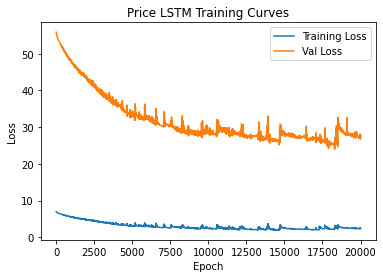

In [218]:
import matplotlib.pyplot as plt

plt.plot(train_loss_log, label = "Training Loss")
plt.plot(val_loss_log, label = "Val Loss")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Price LSTM Training Curves")

Plot Predictions

Test RMSE: 227.36511282791386


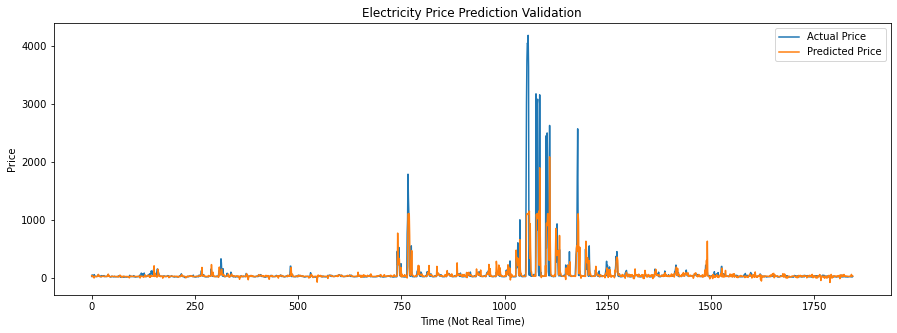

In [231]:
model.eval()
with torch.no_grad():
    Y_test_pred = model(X_test.to(device))
    
# y_test_pred = y_test_pred.cpu().numpy()
# y_test = y_test.to.numpy()

# Calculate RMSE
rmse = np.sqrt(criterion(Y_test.to(device), Y_test_pred).item())
print(f'Test RMSE: {rmse}')

plt.figure(figsize=(15, 5))
plt.plot(Y_test.cpu(), label='Actual Price')
plt.plot(Y_test_pred.cpu(), label='Predicted Price')
plt.title('Electricity Price Prediction Validation')
plt.xlabel('Time (Not Real Time)')
plt.ylabel('Price')
plt.legend()
plt.show()

In [229]:
np.sqrt((criterion(Y_test.to(device)[:1000], Y_test_pred[:1000]).item() + criterion(Y_test.to(device)[1250:], Y_test_pred[1250:]).item()) / 2) 

56.66188394147229

Potential future assessments:

1. Plot fitted values when using the feature vector in LSTM